<h1>Automatic Spindle Detection Spindle Classification Assessment</h1>

In [6]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Importing libraries for statistical testing:
from scipy.stats import ttest_ind

<h2>Importing The Dataset + Preprocessing</h2>

In [7]:
# Absolute filepath for the .csv file to be loaded
absolute_filepath = r"C:\Users\Jason Ha\Documents\University\4th Year\Thesis Project (Repo)\Jupyter Notebooks\Active Projects\split_nobias.csv"

# Loading the .csv file as a dataframe into the workspace.
df = pd.read_csv(absolute_filepath)

# While all other parameters are worth investigating, we want to specifically see how well the following features fare
# in the classification of the spindles, namely the SDT ratio.
important_params = ['a', 'b', 'c', 'd', 'e', 'f', 'sdt_ratio', 'label']
important_params_nolabel = ['a', 'b', 'c', 'd', 'e', 'f', 'sdt_ratio']

# Extracting these from 'df':
df_important = df[important_params]

# We want to see the QPS parameter distribution for the spindles and non-spindles separately and see if there are any
# notable differences. A T-test is performed right after for an proper analytical comparison:
df_important_spin = df_important[(df_important['label'] == 1) & (df_important['a'] > 0)]
df_important_nonspin = df_important[(df_important['label'] == 0) & (df_important['a'] > 0)]

<h3>Spindle Statistics</h3>

In [8]:
df_important_spin[important_params_nolabel].describe().round(5)

,a,b,c,d,e,f,sdt_ratio
count,1246.00000,1246.00000,1246.00000,1.246000e+03,1246.00000,1246.00000,1246.00000
mean,2.15290,-1.16558,-9.48469,5.073270e+05,73.32626,-1.70425,0.68314
std,0.96966,3.85391,8.49892,4.841958e+06,41.41701,8.82529,0.55416
min,0.00994,-18.82522,-85.57190,-1.353855e+07,-104.16220,-39.65505,0.01909
25%,1.48854,-2.96720,-11.95853,-1.864870e+00,79.52022,-5.87485,0.29712
50%,2.48127,-1.11038,-7.49068,-8.497000e-02,84.63452,-1.20569,0.53914
75%,2.90609,0.72973,-4.46893,1.901980e+00,88.29001,2.83977,0.90058
max,3.72912,17.43164,5.85644,6.277819e+07,100.56102,36.75917,5.08243


<h3>Non-Spindle Statistics</h3>

In [9]:
df_important_nonspin[important_params_nolabel].describe().round(5)

,a,b,c,d,e,f,sdt_ratio
count,21204.00000,21204.00000,21204.00000,2.120400e+04,21204.00000,21204.00000,21204.00000
mean,1.75094,-0.35932,-9.93838,6.810784e+05,61.61428,-0.56826,0.55217
std,1.00938,4.08069,9.44683,5.091968e+06,55.12065,11.66811,0.47112
min,0.00017,-27.63193,-164.41102,-4.293681e+07,-134.26811,-195.34151,0.01061
25%,0.72847,-2.32857,-12.88916,-1.874870e+00,76.82678,-5.52532,0.22838
50%,2.01517,-0.64432,-7.57209,2.286200e-01,81.92313,-0.48246,0.41857
75%,2.62007,1.31264,-4.35082,2.379550e+00,85.95440,4.02391,0.73799
max,4.66841,24.75763,13.80118,6.835523e+07,108.79801,155.75469,7.15097


<h2>T-Test For Proper Statistical Comparison Between Features</h2>

For a significance level of $\alpha = 1\%$, only parameter $c$ can be used. However, if we loosen the significance level to $alpha = 5\%$, $c$, $d$ and the $sdt\_ratio$ can be used. We can experiment with this when we come to the neural network model.

In [12]:
# We need to ensure that the lengths of both the spindle and non-spindle dataframe are the same. Truncate the non-spindle
df_important_nonspin = df_important_nonspin.sample(frac=1).reset_index(drop=True)
df_important_nonspin = df_important_nonspin.iloc[0:len(df_important_spin), :]

# Now that the non-spindle subset has been truncated, the T-Test is ready to be used. Recall the significance level of 1%
list_params = ['a', 'b', 'c', 'd', 'e', 'f', 'sdt_ratio']
p = {}

for param in list_params:
    (_, p[param]) = ttest_ind(df_important_spin[param], df_important_nonspin[param])

# Print out the p-values for each parameter:
for param in list_params:
    print("Parameter {}: p = {}".format(param, p[param]))
    
# Return parameters that have p-values below 5% (for lee-way)
selected = []
for param in list_params:
    if p[param] < 0.05:
        selected.append(param)

selected

Parameter a: p = 2.9636429272763515e-23
Parameter b: p = 3.057554695172444e-07
Parameter c: p = 0.16391212794613108
Parameter d: p = 0.49210090403192563
Parameter e: p = 1.8573305806844842e-08
Parameter f: p = 0.0024737202496461232
Parameter sdt_ratio: p = 3.6765804816297845e-15


['a', 'b', 'e', 'f', 'sdt_ratio']

<h2>Preliminary Classification Using Neural Networks</h2>

In [28]:
# Split dataset into spindle and non-spindles:
# Randomise the non-spindle set and truncate so equal in length to the spindle set:
spindles = df_important[df_important['label'] == 1]
non_spindles = df_important[df_important['label'] == 0].sample(frac=1).reset_index(drop = True)

# Truncate non-spindles:
non_spindles = non_spindles.iloc[0:len(spindles), :]

# Concatenate the spindle and non-spindle dataset then jumble once again before splitting into train and test set:
final_df = pd.concat([spindles, non_spindles], axis=0).reset_index(drop=True)

# Split into X and y (feature vectors and label vector):
X = final_df[['a', 'b', 'c', 'd', 'e', 'f', 'sdt_ratio']]
y = final_df['label']

Train on 17347 samples, validate on 4337 samples
Epoch 1/100
17347/17347 [==============================] - 2s 88us/step - loss: 0.6947 - acc: 0.5313 - val_loss: 0.6875 - val_acc: 0.5409
Epoch 2/100
17347/17347 [==============================] - 1s 46us/step - loss: 0.6885 - acc: 0.5395 - val_loss: 0.6868 - val_acc: 0.5398
Epoch 3/100
17347/17347 [==============================] - 1s 46us/step - loss: 0.6875 - acc: 0.5441 - val_loss: 0.6866 - val_acc: 0.5407
Epoch 4/100
17347/17347 [==============================] - 1s 44us/step - loss: 0.6868 - acc: 0.5436 - val_loss: 0.6876 - val_acc: 0.5382
Epoch 5/100
17347/17347 [==============================] - 1s 47us/step - loss: 0.6867 - acc: 0.5450 - val_loss: 0.6870 - val_acc: 0.5418
Epoch 6/100
17347/17347 [==============================] - 1s 57us/step - loss: 0.6864 - acc: 0.5441 - val_loss: 0.6861 - val_acc: 0.5439
Epoch 7/100
17347/17347 [==============================] - 1s 46us/step - loss: 0.6859 - acc: 0.5444 - val_loss: 0.6858 - v

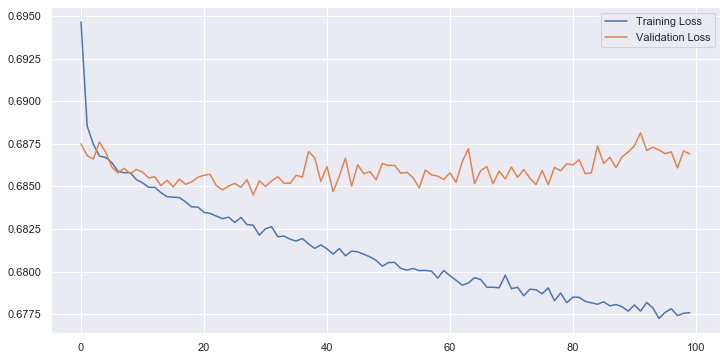

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the 'all_features' dataframe into training and test subsets. CV is performed using 'cross_val_score'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalise training set first and map mean and variance of standardised training set onto the test set.
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

# Importing libraries for machine learning via Keras:
from keras.models import Sequential
from keras.layers import Dense, Activation

model_nn = Sequential()
model_nn.add(Dense(20, activation='relu', input_dim=7))
model_nn.add(Dense(10, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model_nn.fit(X_train, y_train, validation_split=0.2, epochs=100)

# evaluate the model
_, train_acc = model_nn.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_nn.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Perform a prediction using model_nn:
y_pred = model_nn.predict_classes(X_test)

# Compute each metric:
acc = accuracy_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
f1_score = f1_score(y_pred, y_test)

# Print out the metrics:
print("Accuracy = {}".format(acc))
print("Recall = {}".format(recall))
print("Precision = {}".format(precision))
print("F1 Score = {}".format(f1_score))

Accuracy = 0.533935817041682
Recall = 0.5453172205438066
Precision = 0.5218648355619805
F1 Score = 0.5333333333333333


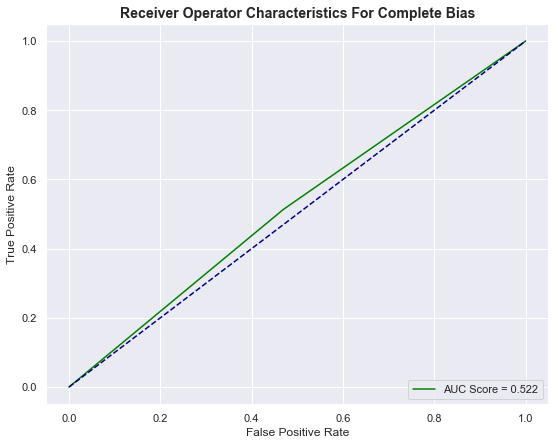

In [18]:
from sklearn.metrics import roc_curve, auc

# The the FPR and TPR from the roc_curve function:
(fpr, tpr, thresholds) = roc_curve(y_pred, y_test)

# Compute the AUC (Area-Under-The-Curve) Score:
auc_score = auc(fpr, tpr)

# Plotting the AUC-ROC curve:
fig, ax = plt.subplots(figsize=(9,7))
plt.title("Receiver Operator Characteristics For Complete Bias", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.plot(fpr, tpr, color='green', label="AUC Score = {}".format(round(auc_score, 3)))
ax.plot([0,1], [0,1], color='navy', linestyle='--')
plt.legend(loc='lower right')
plt.show()

<h3>After Feature Selection (ONLY THE SDT RATIO)</h3>

In [21]:
# New training and label set:
X_new = final_df[['e']]
y_new = final_df['label']

Train on 17347 samples, validate on 4337 samples
Epoch 1/250
17347/17347 [==============================] - 2s 98us/step - loss: 0.6920 - acc: 0.5060 - val_loss: 0.6918 - val_acc: 0.5209
Epoch 2/250
17347/17347 [==============================] - 1s 43us/step - loss: 0.6916 - acc: 0.5148 - val_loss: 0.6918 - val_acc: 0.5181
Epoch 3/250
17347/17347 [==============================] - 1s 44us/step - loss: 0.6914 - acc: 0.5148 - val_loss: 0.6918 - val_acc: 0.5186
Epoch 4/250
17347/17347 [==============================] - 1s 44us/step - loss: 0.6913 - acc: 0.5168 - val_loss: 0.6926 - val_acc: 0.5181
Epoch 5/250
17347/17347 [==============================] - 1s 43us/step - loss: 0.6912 - acc: 0.5156 - val_loss: 0.6916 - val_acc: 0.5195
Epoch 6/250
17347/17347 [==============================] - 1s 44us/step - loss: 0.6914 - acc: 0.5167 - val_loss: 0.6915 - val_acc: 0.5225
Epoch 7/250
17347/17347 [==============================] - 1s 44us/step - loss: 0.6914 - acc: 0.5167 - val_loss: 0.6915 - v

Epoch 118/250
17347/17347 [==============================] - 1s 38us/step - loss: 0.6907 - acc: 0.5166 - val_loss: 0.6916 - val_acc: 0.5211
Epoch 119/250
17347/17347 [==============================] - 1s 42us/step - loss: 0.6907 - acc: 0.5146 - val_loss: 0.6921 - val_acc: 0.5195
Epoch 120/250
17347/17347 [==============================] - 1s 49us/step - loss: 0.6907 - acc: 0.5154 - val_loss: 0.6923 - val_acc: 0.5225
Epoch 121/250
17347/17347 [==============================] - 1s 50us/step - loss: 0.6907 - acc: 0.5165 - val_loss: 0.6929 - val_acc: 0.5209
Epoch 122/250
17347/17347 [==============================] - 1s 45us/step - loss: 0.6907 - acc: 0.5176 - val_loss: 0.6915 - val_acc: 0.5204
Epoch 123/250
17347/17347 [==============================] - 1s 49us/step - loss: 0.6907 - acc: 0.5174 - val_loss: 0.6922 - val_acc: 0.5211
Epoch 124/250
17347/17347 [==============================] - 1s 40us/step - loss: 0.6906 - acc: 0.5163 - val_loss: 0.6923 - val_acc: 0.5179
Epoch 125/250
17347/

17347/17347 [==============================] - 1s 48us/step - loss: 0.6903 - acc: 0.5191 - val_loss: 0.6909 - val_acc: 0.5227
Epoch 235/250
17347/17347 [==============================] - 1s 46us/step - loss: 0.6902 - acc: 0.5170 - val_loss: 0.6906 - val_acc: 0.5197
Epoch 236/250
17347/17347 [==============================] - 1s 42us/step - loss: 0.6901 - acc: 0.5175 - val_loss: 0.6913 - val_acc: 0.5232
Epoch 237/250
17347/17347 [==============================] - 1s 50us/step - loss: 0.6902 - acc: 0.5177 - val_loss: 0.6908 - val_acc: 0.5232
Epoch 238/250
17347/17347 [==============================] - 1s 40us/step - loss: 0.6902 - acc: 0.5177 - val_loss: 0.6913 - val_acc: 0.5227
Epoch 239/250
17347/17347 [==============================] - 1s 49us/step - loss: 0.6902 - acc: 0.5177 - val_loss: 0.6920 - val_acc: 0.5223
Epoch 240/250
17347/17347 [==============================] - 1s 56us/step - loss: 0.6904 - acc: 0.5167 - val_loss: 0.6908 - val_acc: 0.5229
Epoch 241/250
17347/17347 [=======

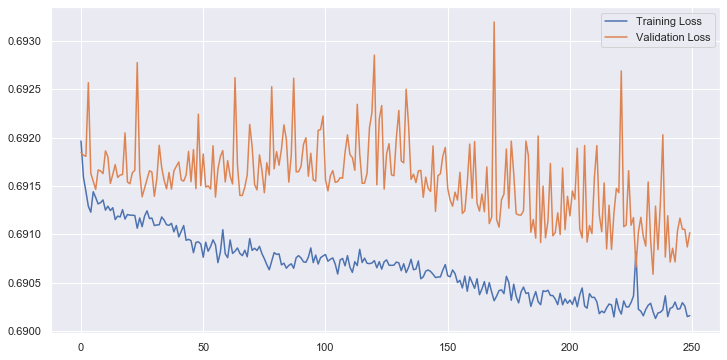

In [22]:
# Train-test splitting:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2)

# Normalise training set first and map mean and variance of standardised training set onto the test set.
std_scale = StandardScaler().fit(X_train_new)
X_train_new = std_scale.transform(X_train_new)
X_test_new = std_scale.transform(X_test_new)

# Importing libraries for machine learning via Keras:
from keras.models import Sequential
from keras.layers import Dense, Activation

model_nn2 = Sequential()
model_nn2.add(Dense(38, activation='relu', input_dim=1))
model_nn2.add(Dense(38, activation='relu'))
model_nn2.add(Dense(1, activation='sigmoid'))

model_nn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model_nn2.fit(X_train_new, y_train_new, validation_split=0.2, epochs=250)

# evaluate the model
_, train_acc = model_nn2.evaluate(X_train_new, y_train_new, verbose=0)
_, test_acc = model_nn2.evaluate(X_test_new, y_test_new, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [99]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Perform a prediction using model_nn:
y_pred2 = model_nn2.predict_classes(X_test_new)

# Compute each metric:
acc2 = accuracy_score(y_pred2, y_test_new)
recall2 = recall_score(y_pred2, y_test_new)
precision2 = precision_score(y_pred2, y_test_new)
f1_score2 = f1_score(y_pred2, y_test_new)

# Print out the metrics:
print("Accuracy = {}".format(acc2))
print("Recall = {}".format(recall2))
print("Precision = {}".format(precision2))
print("F1 Score = {}".format(f1_score2))

Accuracy = 0.49382716049382713
Recall = 0.49794238683127573
Precision = 0.49387755102040815
F1 Score = 0.4959016393442623


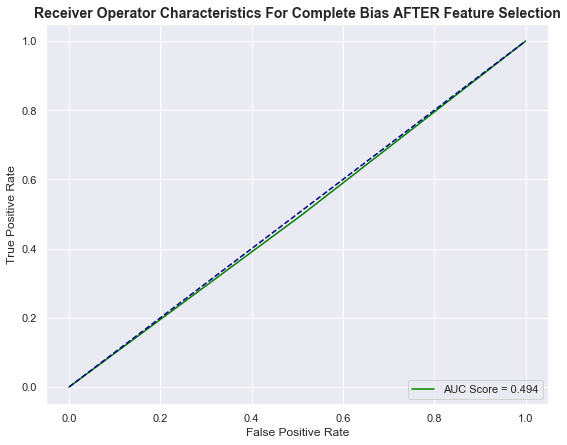

In [100]:
from sklearn.metrics import roc_curve, auc

# The the FPR and TPR from the roc_curve function:
(fpr2, tpr2, thresholds2) = roc_curve(y_pred2, y_test_new)

# Compute the AUC (Area-Under-The-Curve) Score:
auc_score2 = auc(fpr2, tpr2)

# Plotting the AUC-ROC curve:
fig, ax = plt.subplots(figsize=(9,7))
plt.title("Receiver Operator Characteristics For Complete Bias AFTER Feature Selection", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.plot(fpr2, tpr2, color='green', label="AUC Score = {}".format(round(auc_score2, 3)))
ax.plot([0,1], [0,1], color='navy', linestyle='--')
plt.legend(loc='lower right')
plt.show()

Train on 1552 samples, validate on 388 samples
Epoch 1/250
1552/1552 [==============================] - 1s 691us/step - loss: 0.6959 - acc: 0.5129 - val_loss: 0.6946 - val_acc: 0.4716
Epoch 2/250
1552/1552 [==============================] - 0s 60us/step - loss: 0.6945 - acc: 0.5309 - val_loss: 0.6970 - val_acc: 0.4742
Epoch 3/250
1552/1552 [==============================] - 0s 63us/step - loss: 0.6910 - acc: 0.5303 - val_loss: 0.6983 - val_acc: 0.4588
Epoch 4/250
1552/1552 [==============================] - 0s 68us/step - loss: 0.6957 - acc: 0.5213 - val_loss: 0.7006 - val_acc: 0.4510
Epoch 5/250
1552/1552 [==============================] - 0s 78us/step - loss: 0.6957 - acc: 0.5013 - val_loss: 0.6967 - val_acc: 0.4691
Epoch 6/250
1552/1552 [==============================] - 0s 68us/step - loss: 0.6962 - acc: 0.5238 - val_loss: 0.6974 - val_acc: 0.4691
Epoch 7/250
1552/1552 [==============================] - 0s 61us/step - loss: 0.6947 - acc: 0.5129 - val_loss: 0.6977 - val_acc: 0.4768


Epoch 120/250
1552/1552 [==============================] - 0s 68us/step - loss: 0.6885 - acc: 0.5380 - val_loss: 0.6976 - val_acc: 0.4794
Epoch 121/250
1552/1552 [==============================] - 0s 66us/step - loss: 0.6877 - acc: 0.5387 - val_loss: 0.6979 - val_acc: 0.4742
Epoch 122/250
1552/1552 [==============================] - 0s 64us/step - loss: 0.6867 - acc: 0.5457 - val_loss: 0.7006 - val_acc: 0.4716
Epoch 123/250
1552/1552 [==============================] - 0s 65us/step - loss: 0.6881 - acc: 0.5399 - val_loss: 0.6991 - val_acc: 0.4742
Epoch 124/250
1552/1552 [==============================] - 0s 67us/step - loss: 0.6892 - acc: 0.5393 - val_loss: 0.6997 - val_acc: 0.4716
Epoch 125/250
1552/1552 [==============================] - 0s 68us/step - loss: 0.6879 - acc: 0.5445 - val_loss: 0.6987 - val_acc: 0.4794
Epoch 126/250
1552/1552 [==============================] - 0s 69us/step - loss: 0.6907 - acc: 0.5322 - val_loss: 0.6998 - val_acc: 0.4794
Epoch 127/250
1552/1552 [=========

1552/1552 [==============================] - 0s 65us/step - loss: 0.6824 - acc: 0.5554 - val_loss: 0.7034 - val_acc: 0.4820
Epoch 239/250
1552/1552 [==============================] - 0s 61us/step - loss: 0.6848 - acc: 0.5425 - val_loss: 0.7021 - val_acc: 0.4845
Epoch 240/250
1552/1552 [==============================] - 0s 64us/step - loss: 0.6833 - acc: 0.5496 - val_loss: 0.7032 - val_acc: 0.4716
Epoch 241/250
1552/1552 [==============================] - 0s 58us/step - loss: 0.6845 - acc: 0.5580 - val_loss: 0.7027 - val_acc: 0.4665
Epoch 242/250
1552/1552 [==============================] - 0s 63us/step - loss: 0.6825 - acc: 0.5657 - val_loss: 0.7072 - val_acc: 0.4665
Epoch 243/250
1552/1552 [==============================] - 0s 63us/step - loss: 0.6831 - acc: 0.5586 - val_loss: 0.7099 - val_acc: 0.4768
Epoch 244/250
1552/1552 [==============================] - 0s 61us/step - loss: 0.6841 - acc: 0.5528 - val_loss: 0.7065 - val_acc: 0.4768
Epoch 245/250
1552/1552 [=======================

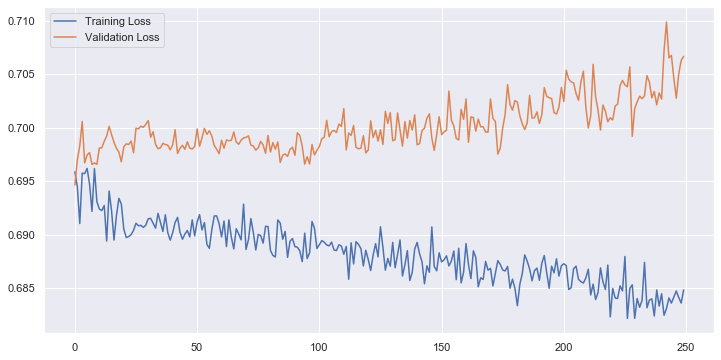

In [101]:
# Train-test splitting:
X_train_new2, X_test_new2, y_train_new2, y_test_new2 = train_test_split(X_new, y_new, test_size=0.2)

# Normalise training set first and map mean and variance of standardised training set onto the test set.
std_scale = StandardScaler().fit(X_train_new2)
X_train_new2 = std_scale.transform(X_train_new2)
X_test_new2 = std_scale.transform(X_test_new2)

# Importing libraries for machine learning via Keras:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout

model_nn3 = Sequential()
model_nn3.add(Dense(38, activation='relu', input_dim=3))
model_nn3.add(Dropout(0.2))
model_nn3.add(Dense(38, activation='relu'))
model_nn3.add(Dropout(0.2))
model_nn3.add(Dense(1, activation='sigmoid'))

model_nn3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model_nn3.fit(X_train_new2, y_train_new2, validation_split=0.2, epochs=250)

# evaluate the model
_, train_acc = model_nn3.evaluate(X_train_new2, y_train_new2, verbose=0)
_, test_acc = model_nn3.evaluate(X_test_new2, y_test_new2, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot training history
fig = plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [102]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Perform a prediction using model_nn:
y_pred3 = model_nn3.predict_classes(X_test_new2)

# Compute each metric:
acc3 = accuracy_score(y_pred3, y_test_new2)
recall3 = recall_score(y_pred3, y_test_new2)
precision3 = precision_score(y_pred3, y_test_new2)
f1_score3 = f1_score(y_pred3, y_test_new2)

# Print out the metrics:
print("Accuracy = {}".format(acc3))
print("Recall = {}".format(recall3))
print("Precision = {}".format(precision3))
print("F1 Score = {}".format(f1_score3))

Accuracy = 0.5308641975308642
Recall = 0.5487179487179488
Precision = 0.4331983805668016
F1 Score = 0.4841628959276018


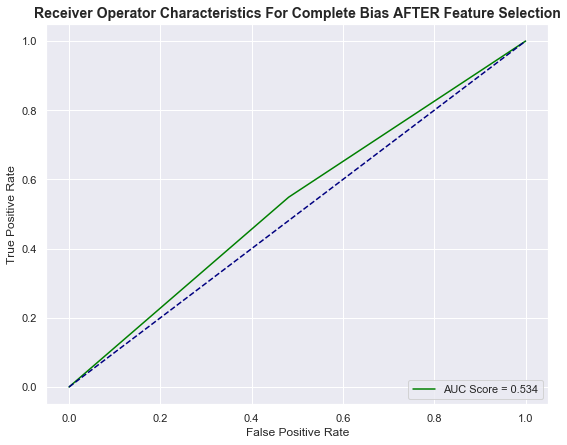

In [103]:
from sklearn.metrics import roc_curve, auc

# The the FPR and TPR from the roc_curve function:
(fpr3, tpr3, thresholds3) = roc_curve(y_pred3, y_test_new2)

# Compute the AUC (Area-Under-The-Curve) Score:
auc_score3 = auc(fpr3, tpr3)

# Plotting the AUC-ROC curve:
fig, ax = plt.subplots(figsize=(9,7))
plt.title("Receiver Operator Characteristics For Complete Bias AFTER Feature Selection", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.plot(fpr3, tpr3, color='green', label="AUC Score = {}".format(round(auc_score3, 3)))
ax.plot([0,1], [0,1], color='navy', linestyle='--')
plt.legend(loc='lower right')
plt.show()